<a href="https://colab.research.google.com/github/nicoelbert/vehicleroutingproblem/blob/main/vehicle_routing_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem
vehicle routing problem on complete information using simmulated annealing

#Preparation

In [3]:
#inital run
if False:
  !git clone 'https://github.com/nicoelbert/vehicleroutingproblem'
  %cd vehicleroutingproblem

fatal: destination path 'vehicleroutingproblem' already exists and is not an empty directory.
/content/vehicleroutingproblem


In [13]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt

#custom calsses
!git pull
from classes import classes as cl
from functions import functions as fc


Already up to date.


In [14]:
!git pull
!ls

Already up to date.
classes  functions  original_data  README.md  vehicle_routing_solver.ipynb


##Data Import

In [15]:
#depot masterdata

#load Masterdata from csv
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/Depots.csv'
df_depots = pd.read_csv(url)


#load basetable
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/preparedJobs.csv'
df_jobs_org = pd.read_csv(url)

#create and fill dict_depots

dict_depots = {}
list_depots = []

for index, row in df_depots.iterrows():
  depot = cl.Depot(row['Werk'],row['Werk_lon'],row['Werk_lat'])
  dict_depots[row['Werk']] = depot
  list_depots.append(depot)

print("{} depots created".format(len(dict_depots)))


#create and fill plants from df_jobs_org
dict_plants = {}
list_plants = []

list_plant_names = df_jobs_org['Werk'].unique() 

for pn in list_plant_names:
  row = df_jobs_org[df_jobs_org['Werk'] == pn].iloc[0]
  plant = cl.Plant(row.Werk,row.Werk_lon,row.Werk_lat)
  dict_plants[plant.name] = plant
  list_plants.append(plant)

print("{} plants created".format(len(dict_plants)))


#create and fill sites from df_jobs_org

dict_sites = {}
list_sites = []

df_sites = df_jobs_org[['plz','lon','lat']].copy()
df_sites.drop_duplicates(inplace=True)


for index, row in df_sites.iterrows():
  site = cl.Site(row.plz,row.lon,row.lat)
  dict_sites[site.name] = site
  list_sites.append(site)


print("{} sites created".format(len(dict_sites)))


#create and fill jobs from df_jobs_org


dict_jobs = {}
list_jobs = []
list_emsen_jobs = []

for index, row in df_jobs_org.iterrows():
  plant = dict_plants[row.Werk]
  site_name = str(row.plz) + '/' +str(row.lon) + '/' + str(row.lat)
  site = dict_sites[site_name]
  prox_depot = dict_depots[row.Depot]
  job = cl.Job(row.id, row.key, plant,row.Maschinentechnik,row.Material,row.Start_clean,row.End, row.Werktage, site, prox_depot )
  dict_jobs[job.id] = job
  list_jobs.append(job)



print("{} jobs created".format(len(dict_jobs)))


15 depots created
8 plants created
6166 sites created
53178 jobs created


In [16]:
list_emsen_sites = []

for j in list_jobs:
  if j.depot == dict_depots['Embsen']:
    if j.site not in list_emsen_sites:
      list_emsen_sites.append(j.site)

len(list_emsen_sites)

789

In [17]:
for d in list_depots:
  print(d.name)

Neuherberg
Lauterhofen
Altbach
Deisslingen
Bollschweil
Lampertheim
Neuss
Embsen
Rottleberode
Fenne
Castrop
Perl
Gnetsch
Vogelsdorf
Sukow


Visualize Data


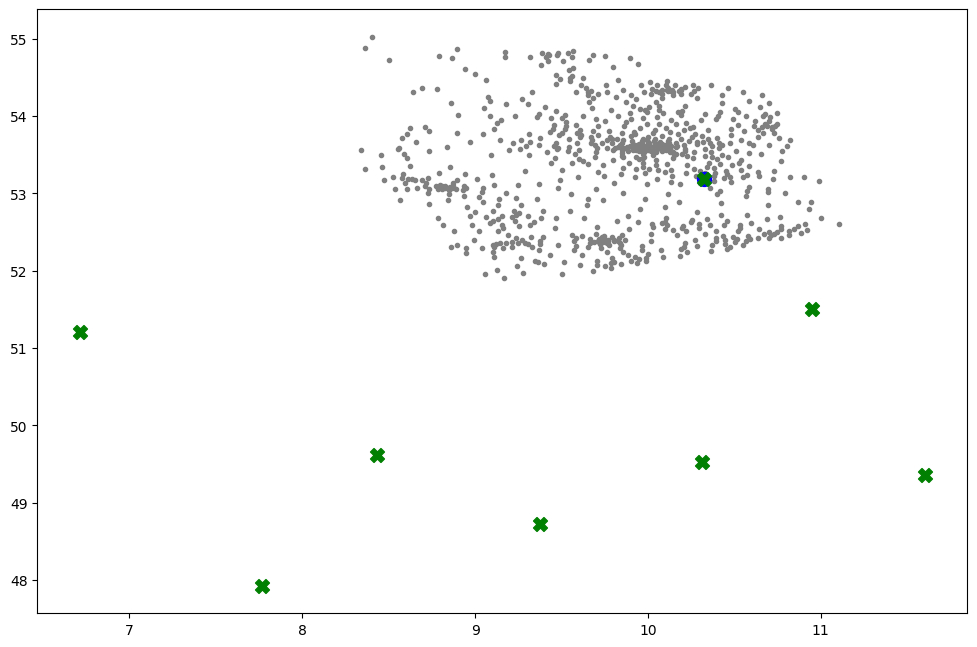

In [28]:
fc.get_map([list_depots[7]],list_plants,list_emsen_sites)

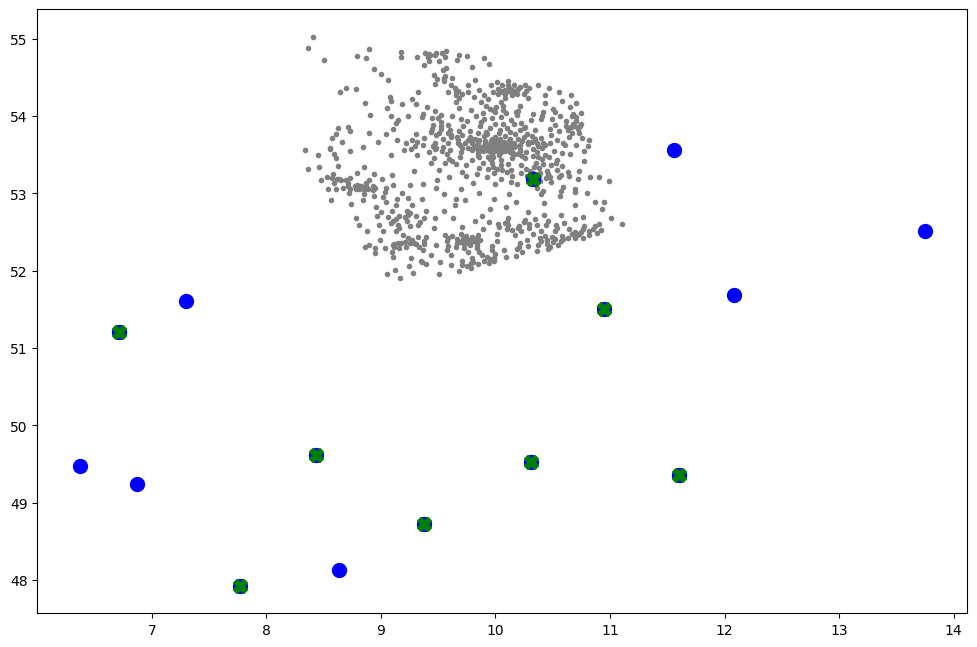

In [29]:
fc.get_map(list_depots,list_plants,list_emsen_sites)

In [ ]:
#create inital solution
""" every silo is delivered on the day it is needed 
"""

for j in jobs:
  pickup

##Backup

In [ ]:
#notes
"inital solution transport every silo back and forth on a tour prior to the"

In [ ]:
#question
"really repos or whole problem?"



"how many silos"
"max_km"
"how early"

In [ ]:
#assumption
"""
max_km? 
max_tour/depot = 1

In [ ]:
#backup

#distance depot,plants
"""
for d in list_depots:
  for p in list_plants:
    print('{} nach {} sind {}'.format(d.name,p.name,fc.get_distance(d,p)))
"""

"""
"eval of sites"
print(len(df_jobs['plz'].unique()))
print(len(df_jobs['lon'].unique()))
print(len(df_jobs['lat'].unique()))
#print(len(df_jobs[['lon','lat']]()))

df_sites = df_jobs[['lon','lat']].copy()

print(df_sites.shape)

df_sites.drop_duplicates(inplace=True)


print(df_sites.shape)
k.key
"""
